## Problem Statement :  **Oilfield Lithology Prediction**


> Lithology refers to the type of rock. Lithology is classified into, for instance, sandstone, claystone, marl, limestone, and dolomite.
>
>It is common to predict lithology from geophysical logs because these logs are direct proxies of lithology. There have been already numerous works in this field of application, even there have been already two public contests here (2016 [link text](https://agilescientific.com/blog/2016/12/8/seg-machine-learning-contest-theres-still-time)) and [here](https://www.npd.no/en/force/Previous-events/machine-learning-contest-with-wells-and-seismic/) (2020).
>
>Lithology prediction based on drilling data will be useful for real-time geosteering in the oil and gas industry.



## Overview of the data

> the dataset from the Volve Field provided for the public by Equinor from this [link](https://github.com/yohanesnuwara/volve-machine-learning/blob/main/Realtime_Drilling_F_15.csv).
>
>The data is measurements obtained from drilling data
>
>There are 5 lithologies classes in the LITH column: sandstone, claystone, marl, limestone, and dolomite. Since limestone and dolomite have the least number of observations, we will only use **sandstone, claystone, and marl** for our classification.
>
>

In [ ]:
!pip install scikit-learn==1.2.2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
path = 'https://raw.githubusercontent.com/yohanesnuwara/volve-machine-learning/main/Realtime_Drilling_F_15.csv'

df = pd.read_csv(path)

df.head()

,Depth,LAGMWT,Time,EditFlag,TORQUE,MOTOR_RPM,STRATESUM,MWOUT,LAGMWDIFF,MWIN,...,LAGMRDIFF,FLOWIN,WOB,ONBOTTOM_TIME,ECDBIT,MTOUT,BIT_DIST,SURF_RPM,LAGMTDIFF,LITH
0,3300.0,1280.0000,2013-11-28 12:54:29,0.0,3768.1461,0.0,0.300773,1280.0000,0.000000,1280.0000,...,0.0,0.006662,-19762.743,194.0,1293.6605,0.0,0.995211,0.267094,0.0,claystone
1,3305.0,1280.0000,2013-11-28 16:48:21,0.0,20991.5430,0.0,1.674558,1306.2254,26.225434,1306.2254,...,0.0,0.037091,26217.864,1617.0,1360.8740,0.0,5.995622,1.314720,0.0,marl
2,3310.0,1315.2258,2013-11-28 17:01:59,0.0,22610.3830,0.0,1.766764,1320.0146,4.788793,1320.0146,...,0.0,0.039134,83492.293,2435.0,1382.0713,0.0,10.997926,1.328674,0.0,marl
3,3315.0,1320.0008,2013-11-28 17:46:39,0.0,24296.9810,0.0,1.768285,1320.0000,-0.000815,1320.0000,...,0.0,0.039168,97087.882,3442.0,1381.7741,0.0,15.997564,1.420116,0.0,claystone
4,3320.0,1320.0000,2013-11-28 18:02:50,0.0,24931.3130,0.0,1.783305,1320.0000,-0.000002,1320.0000,...,0.0,0.039500,54793.206,4333.0,1381.5933,0.0,20.990649,1.593931,0.0,claystone


In [5]:
# Drop time column
df = df.drop(['Time'], axis=1)

df.head()

,Depth,LAGMWT,EditFlag,TORQUE,MOTOR_RPM,STRATESUM,MWOUT,LAGMWDIFF,MWIN,BIT_RPM,...,LAGMRDIFF,FLOWIN,WOB,ONBOTTOM_TIME,ECDBIT,MTOUT,BIT_DIST,SURF_RPM,LAGMTDIFF,LITH
0,3300.0,1280.0000,0.0,3768.1461,0.0,0.300773,1280.0000,0.000000,1280.0000,0.267094,...,0.0,0.006662,-19762.743,194.0,1293.6605,0.0,0.995211,0.267094,0.0,claystone
1,3305.0,1280.0000,0.0,20991.5430,0.0,1.674558,1306.2254,26.225434,1306.2254,1.314148,...,0.0,0.037091,26217.864,1617.0,1360.8740,0.0,5.995622,1.314720,0.0,marl
2,3310.0,1315.2258,0.0,22610.3830,0.0,1.766764,1320.0146,4.788793,1320.0146,1.328706,...,0.0,0.039134,83492.293,2435.0,1382.0713,0.0,10.997926,1.328674,0.0,marl
3,3315.0,1320.0008,0.0,24296.9810,0.0,1.768285,1320.0000,-0.000815,1320.0000,1.420887,...,0.0,0.039168,97087.882,3442.0,1381.7741,0.0,15.997564,1.420116,0.0,claystone
4,3320.0,1320.0000,0.0,24931.3130,0.0,1.783305,1320.0000,-0.000002,1320.0000,1.595948,...,0.0,0.039500,54793.206,4333.0,1381.5933,0.0,20.990649,1.593931,0.0,claystone


>Below shows that the data has imbalanced number of observations which cause  imbalanced classification.





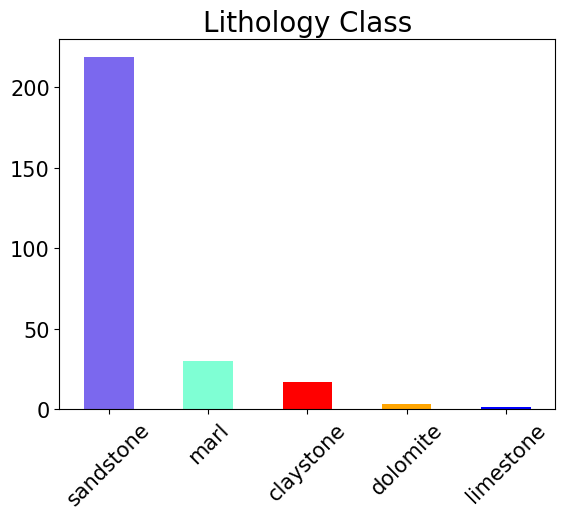

In [6]:
# df.LITH.value_counts().plot(kind='pie', figsize=(7,7), autopct='%1.1f%%', fontsize=20)
df.LITH.value_counts().plot(kind='bar', fontsize=15, rot=45,
                            color=['mediumslateblue', 'aquamarine', 'red', 'orange', 'blue'])
plt.title('Lithology Class', size=20);

In [7]:
# Remove limestone and dolomite
df = df[(df.LITH!='limestone') & (df.LITH!='dolomite')]

df.head()

,Depth,LAGMWT,EditFlag,TORQUE,MOTOR_RPM,STRATESUM,MWOUT,LAGMWDIFF,MWIN,BIT_RPM,...,LAGMRDIFF,FLOWIN,WOB,ONBOTTOM_TIME,ECDBIT,MTOUT,BIT_DIST,SURF_RPM,LAGMTDIFF,LITH
0,3300.0,1280.0000,0.0,3768.1461,0.0,0.300773,1280.0000,0.000000,1280.0000,0.267094,...,0.0,0.006662,-19762.743,194.0,1293.6605,0.0,0.995211,0.267094,0.0,claystone
1,3305.0,1280.0000,0.0,20991.5430,0.0,1.674558,1306.2254,26.225434,1306.2254,1.314148,...,0.0,0.037091,26217.864,1617.0,1360.8740,0.0,5.995622,1.314720,0.0,marl
2,3310.0,1315.2258,0.0,22610.3830,0.0,1.766764,1320.0146,4.788793,1320.0146,1.328706,...,0.0,0.039134,83492.293,2435.0,1382.0713,0.0,10.997926,1.328674,0.0,marl
3,3315.0,1320.0008,0.0,24296.9810,0.0,1.768285,1320.0000,-0.000815,1320.0000,1.420887,...,0.0,0.039168,97087.882,3442.0,1381.7741,0.0,15.997564,1.420116,0.0,claystone
4,3320.0,1320.0000,0.0,24931.3130,0.0,1.783305,1320.0000,-0.000002,1320.0000,1.595948,...,0.0,0.039500,54793.206,4333.0,1381.5933,0.0,20.990649,1.593931,0.0,claystone


## Feature Selection

>Do not need all of these 30 features for our prediction. Some of them are erroneous and redunant", which there is need to Feature Selection.

### 1. Feature Selection by excluding erroneous features

> Dataframe.describe() to print the summary stats. The following is a selected summary stats of some features.

> The features that is erroneous based on below summary :
*   Both RigActivityCode and DXC have constant values because the mean, min, max, and percentiles are equal. These features are erroneous, therefore can’t be used
*   “RigActivityCode” is just an annotation that doesn't have any significance.
*   MWIN shows all equal percentiles and max, while LAGMTDIFF shows all equal percentiles and min.


In [8]:
some_erroneous_features = ['RigActivityCode', 'DXC', 'MWIN', 'LAGMTDIFF', 'WOB']
summary_stats_erroneous = df[some_erroneous_features].describe().round(2) # Suppress scientific notation

summary_stats_erroneous

,RigActivityCode,DXC,MWIN,LAGMTDIFF,WOB
count,266.0,266.00,266.00,266.00,266.00
mean,111.0,0.99,1319.80,-286.16,57460.18
std,0.0,0.00,2.59,69.65,122318.81
min,111.0,0.99,1280.00,-303.15,-43003.60
25%,111.0,0.99,1320.00,-303.15,37032.77
50%,111.0,0.99,1320.00,-303.15,45629.43
75%,111.0,0.99,1320.00,-303.15,55076.90
max,111.0,0.99,1320.01,0.00,1857840.10


Another way to spot erroneous features is to identify the percentage of data having zeros. Here, we have calculated the percentage.


In [9]:
# Calculate proportion of zeroes in each feature
for col in df.columns:
  sum_zeros = (df[col]==0).sum()
  pct_zeros = sum_zeros / len(df) * 100
  print(f'{col}: {pct_zeros:.0f}%')

Depth: 0%
LAGMWT: 0%
EditFlag: 100%
TORQUE: 0%
MOTOR_RPM: 100%
STRATESUM: 0%
MWOUT: 0%
LAGMWDIFF: 81%
MWIN: 0%
BIT_RPM: 0%
DXC: 0%
MUDRETDEPTH: 0%
PUMP: 0%
LAGMTEMP: 5%
RigActivityCode: 0%
MRIN: 100%
FLOWOUT: 0%
ROP_AVG: 0%
LAGMRES: 100%
TOTGAS: 0%
MROUT: 100%
MTIN: 4%
LAGMRDIFF: 100%
FLOWIN: 0%
WOB: 0%
ONBOTTOM_TIME: 0%
ECDBIT: 0%
MTOUT: 100%
BIT_DIST: 0%
SURF_RPM: 0%
LAGMTDIFF: 5%
LITH: 0%


Erroneus features:

* MOTOR_RPM, MTOUT, MROUT, MRIN, LAGMRES, LAGMRDIFF, and EditFlag have all zeros
* DXC and RigActivityCode have all same values, 0.98767 and 111, respectively
* MWIN, LAGMTEMP, MTIN, MWOUT, LAGMTDIFF, and LAGMWT have all percentiles and maximum value similar
* LAGMWDIFF has 80% zero values and very large maximum value (outlier)
* WOB has negative minimum value (which can't be true) and very large maximum value (outlier)

All these erroneus features won't be used in our prediction, except for WOB, we can remove the outliers and still use it.

In [10]:
erroneous_feature = ['MOTOR_RPM', 'MTOUT', 'MROUT', 'MRIN', 'LAGMRES', 'LAGMRDIFF',
                    'EditFlag', 'DXC', 'RigActivityCode', 'LAGMWT', 'MWIN',
                    'LAGMTEMP', 'MTIN', 'MWOUT', 'LAGMTDIFF', 'LAGMWDIFF']
df = df.drop(erroneous_feature, axis=1)

# Manually remove outliers from WOB
df = df[(df.WOB<1e6) & (df.WOB>0)].reset_index(drop=True)

df.head()

,Depth,TORQUE,STRATESUM,BIT_RPM,MUDRETDEPTH,PUMP,FLOWOUT,ROP_AVG,TOTGAS,FLOWIN,WOB,ONBOTTOM_TIME,ECDBIT,BIT_DIST,SURF_RPM,LITH
0,3305.0,20991.543,1.674558,1.314148,3301.7245,17932214.0,0.038981,0.004088,0.000183,0.037091,26217.864,1617.0,1360.8740,5.995622,1.314720,marl
1,3310.0,22610.383,1.766764,1.328706,3301.7245,20878002.0,0.041079,0.005159,0.000176,0.039134,83492.293,2435.0,1382.0713,10.997926,1.328674,marl
2,3315.0,24296.981,1.768285,1.420887,3302.8926,20728354.0,0.041359,0.005971,0.000188,0.039168,97087.882,3442.0,1381.7741,15.997564,1.420116,claystone
3,3320.0,24931.313,1.783305,1.595948,3306.1559,20553813.0,0.043607,0.005419,0.000276,0.039500,54793.206,4333.0,1381.5933,20.990649,1.593931,claystone
4,3325.0,24330.264,1.783333,1.653237,3311.3763,20492430.0,0.043191,0.005435,0.000253,0.039501,50301.579,5255.0,1381.1635,25.996929,1.653262,marl


### 2. Redundant features

>Redundant features have characteristics of having high correlation among themselves.
>
>We can plot a heatmap of correlations among these variables. Spearman’s correlation is used.
>
>The rule for our feature selection is that highly correlated features will not be used.

In [11]:
def corr_heatmap(df):
  # Generate a mask for the upper triangle
  mask = np.zeros_like(df.corr(method = 'spearman') , dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True

  # Generate a custom diverging colormap
  cmap = sns.cubehelix_palette(n_colors=12, start=-2.25, rot=-1.3, as_cmap=True)
  cmap = 'PRGn'
  cmap = 'plasma'

  # Draw the heatmap with the mask and correct aspect ratio
  plt.figure(figsize=(12,10))
  sns.heatmap(df.corr(method = 'spearman') ,annot=True,  mask=mask, cmap=cmap,
              vmin=0, vmax=1, square=True)

  plt.show()

<ipython-input-11-ad368dc893e0>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df.corr(method = 'spearman') , dtype=np.bool)


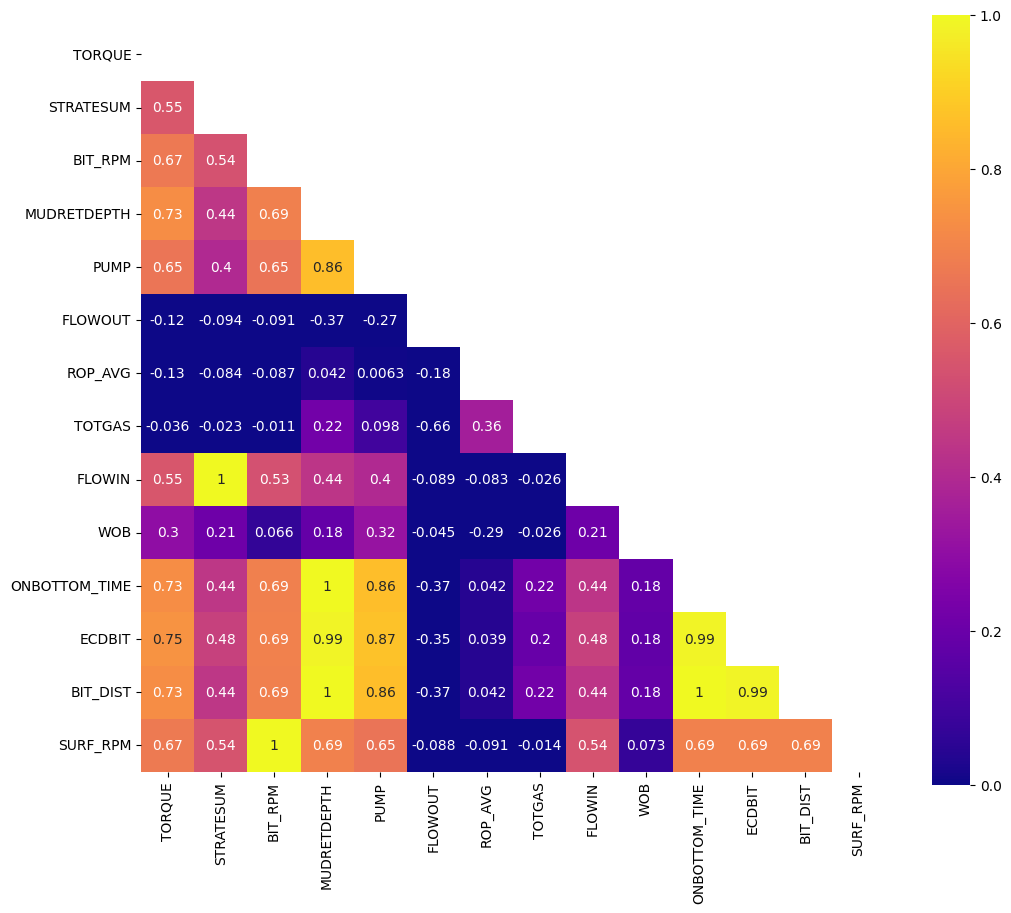

In [12]:
# All features without depth
no_depth = df.columns[1:]

# Plot correlation heatmap
corr_heatmap(df[no_depth])

> Remove the SURF_RPM because SURF_RPM (Rotation per minute on the surface) is correlated to the BIT_RPM (Rotation per minute at drill bit)
>
> Remove MUDRETDEPTH, BIT_DIST, ONBOTTOM_TIME because all these three are correlated.
>
>Remove FLOWIN (mud flow in) because it is related to the STRATESUM (pump total stroke rate) because when mud flows in, drilling engineers get the pump measurement.
>



In [13]:
# Remove correlated features
correlated_feature = ['MUDRETDEPTH', 'BIT_DIST', 'ONBOTTOM_TIME', 'SURF_RPM', 'FLOWIN']
df = df.drop(correlated_feature, axis=1)

df.head()

,Depth,TORQUE,STRATESUM,BIT_RPM,PUMP,FLOWOUT,ROP_AVG,TOTGAS,WOB,ECDBIT,LITH
0,3305.0,20991.543,1.674558,1.314148,17932214.0,0.038981,0.004088,0.000183,26217.864,1360.8740,marl
1,3310.0,22610.383,1.766764,1.328706,20878002.0,0.041079,0.005159,0.000176,83492.293,1382.0713,marl
2,3315.0,24296.981,1.768285,1.420887,20728354.0,0.041359,0.005971,0.000188,97087.882,1381.7741,claystone
3,3320.0,24931.313,1.783305,1.595948,20553813.0,0.043607,0.005419,0.000276,54793.206,1381.5933,claystone
4,3325.0,24330.264,1.783333,1.653237,20492430.0,0.043191,0.005435,0.000253,50301.579,1381.1635,marl


### 3. Selected features
>
> Reduced 30 features to only 9 features! The features are as follows:
* TORQUE: Surface torque average (N.m)
* STRATESUM: Pump total stroke rate (Hz)
* BIT_RPM: Rotation per minute at drill bit (c/s)
* PUMP: Pump pressure (Pa)
* FLOWOUT: Mud flow out (m3/s)
* ROP_AVG: Depth averaged rotation per minute (m/s)
* TOTGAS: Total gas content (ppm)
* WOB: Weight on bit (N)
* ECDBIT: Effective circulating density on bit (kg/m3)



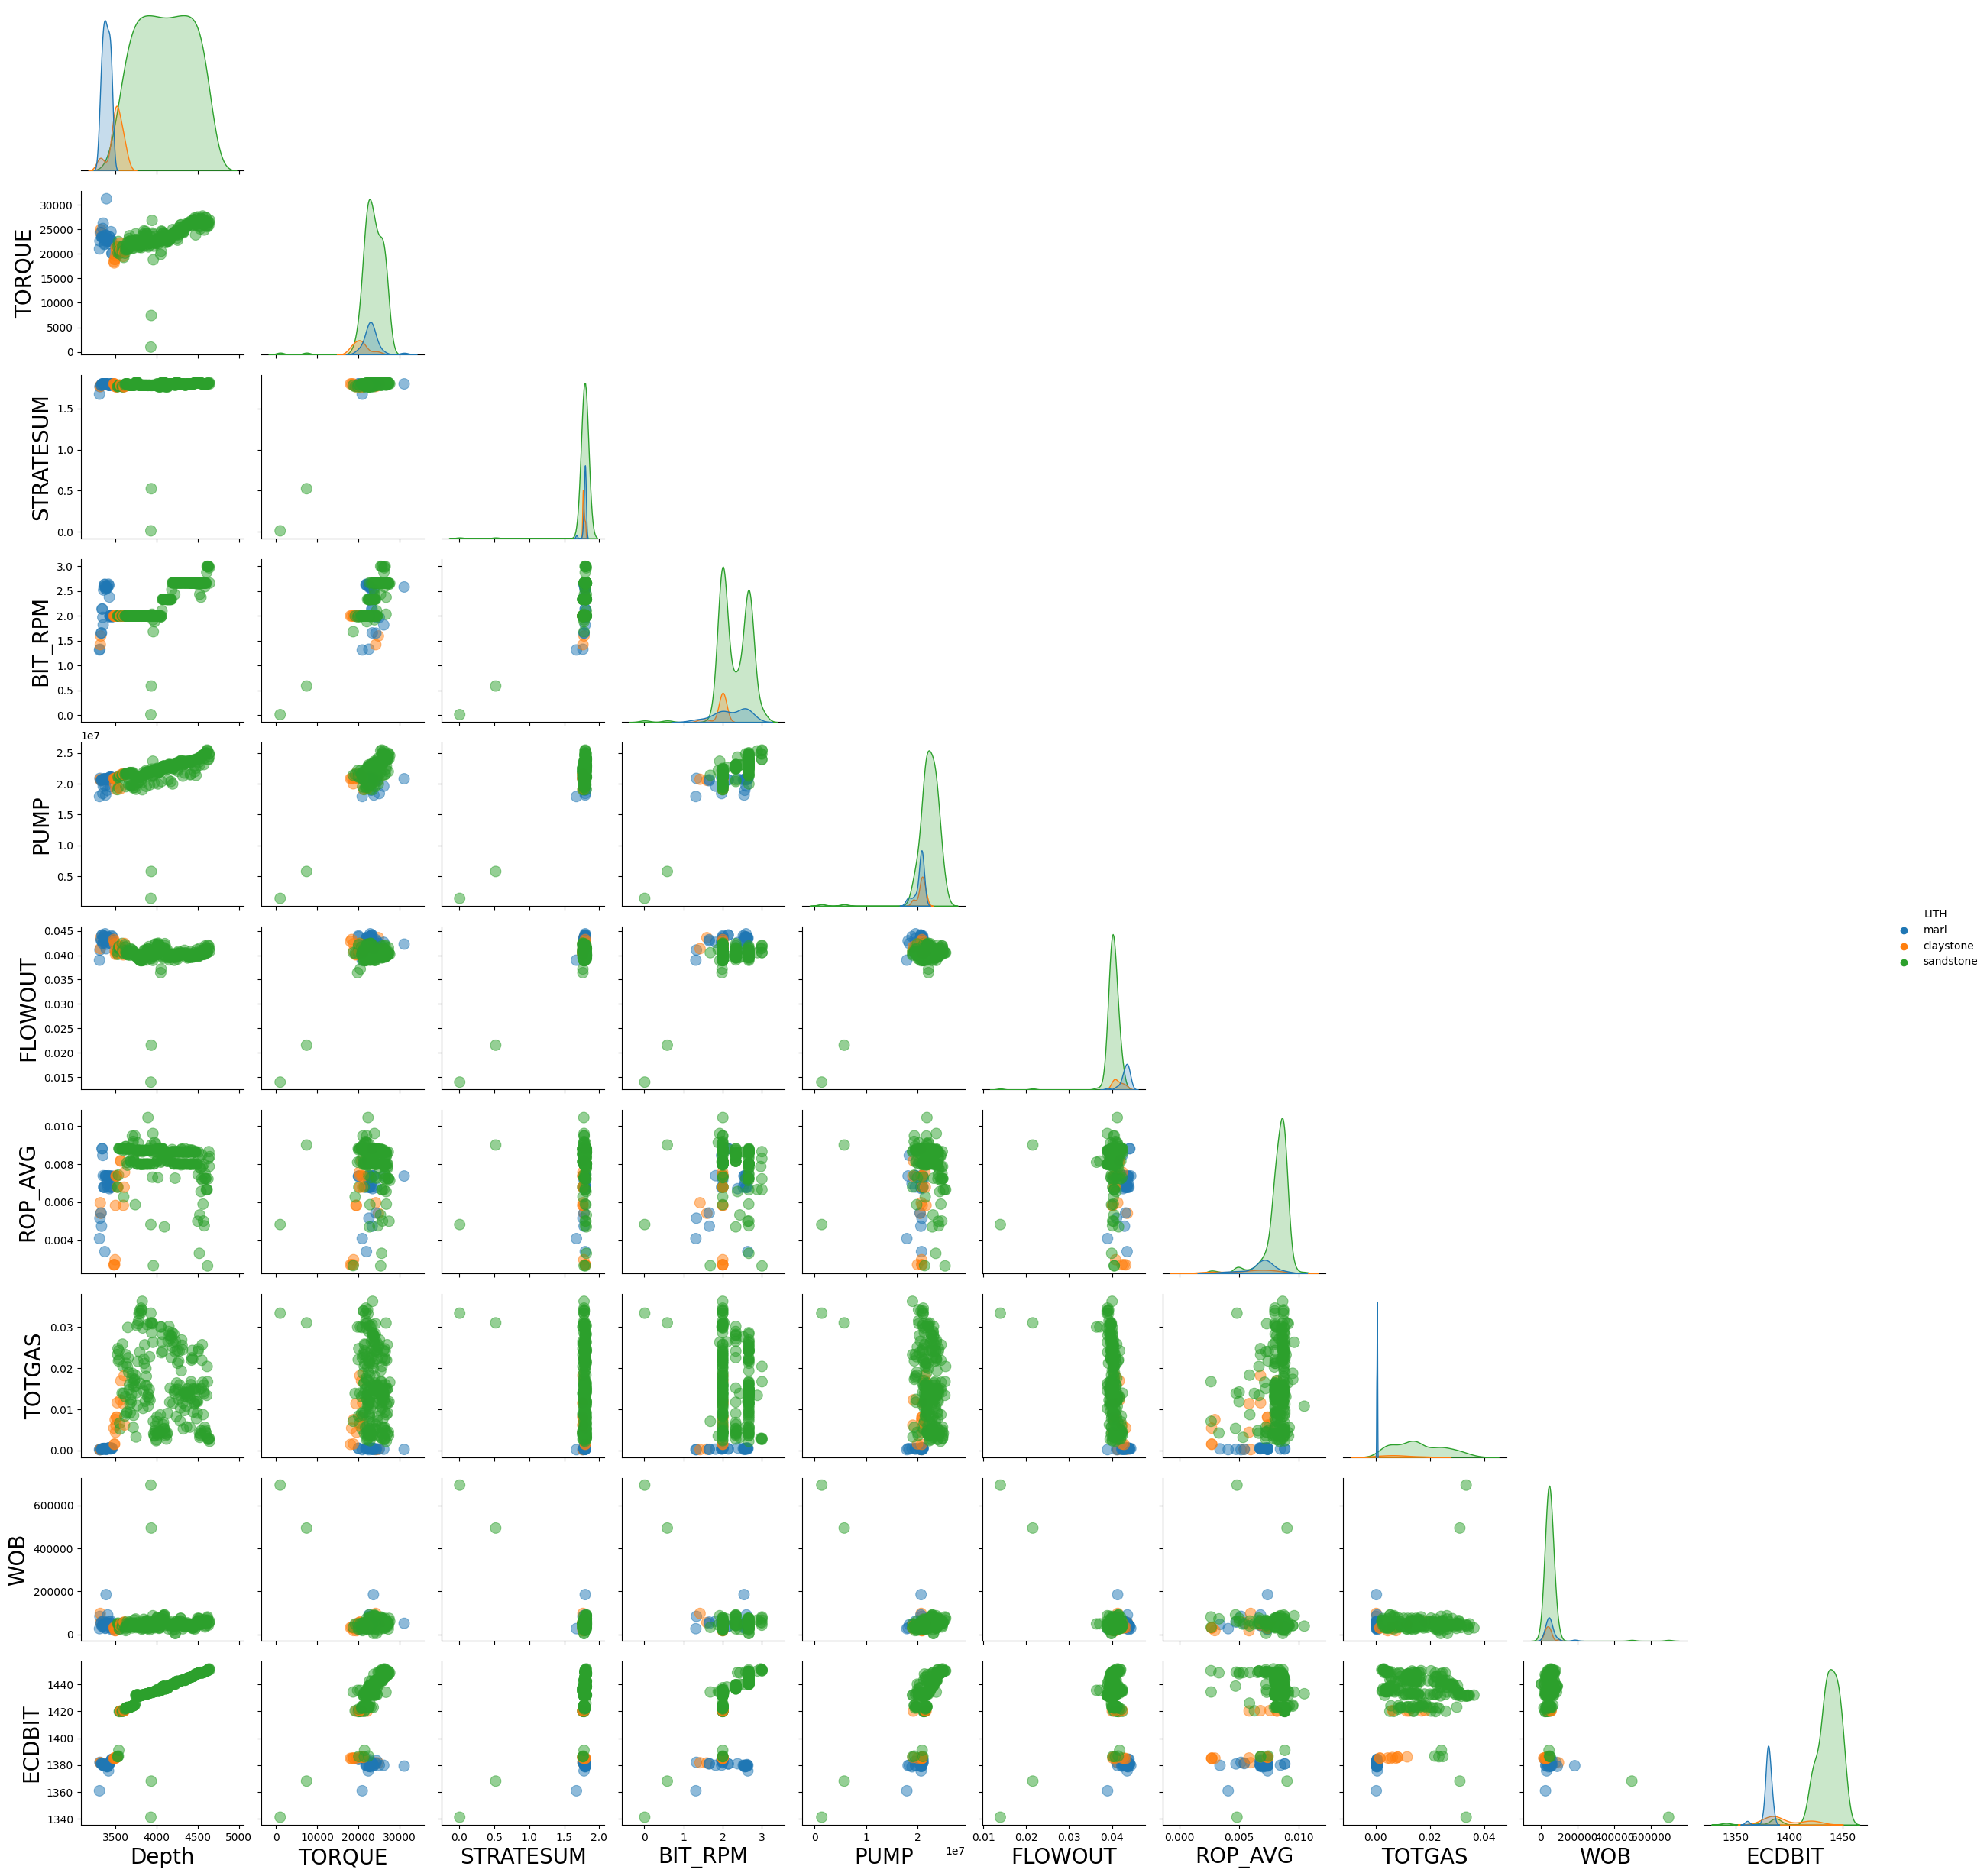

In [14]:
# Plot pairplot
plt.rcParams["axes.labelsize"] = 20
g = sns.pairplot(df, hue='LITH', corner=True,
                 plot_kws = {'alpha': 0.5, 's': 100, 'edgecolor':None})

## Train-test split, oversampling with SMOTE, cross-validation, then prediction

> Oversampling with SMOTE (Synthetic Minority Over-sampling Technique) because number of observations of our classes is imbalanced.
>
> Prediction is done using stratified sampling instead of random sampling by defining stratify parameter as it is useful for imbalanced cases
>
>To streamline our training process, we build a pipeline that contains StandardScaler normalization, SMOTE oversampler, and AdaBoostClassifier model.

In [15]:
# Drop depth column

# Separate feature and target
X, y = df.iloc[:,1:-1], df['LITH']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.30)
# Define oversampling
over = SMOTE(k_neighbors=4)

# Define model
model = AdaBoostClassifier()

# Define normalization
norm = StandardScaler()

# Put into pipeline
steps = [('norm', norm), ('o', over), ('model', model)]
pipe = Pipeline(steps=steps)

scoring = ['accuracy', 'precision_macro', 'recall_macro']
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores_pipe = cross_validate(pipe, X_train, y_train,
                            scoring=scoring, cv=cv, n_jobs=-1)

# Oversampling test data
over = SMOTE(k_neighbors=4)
X_test, y_test = over.fit_resample(X_test, y_test)

>Using the AdaBoost classifier, we achieve 96% accuracy, 86% precision, and 89% recall.
>
>This is a good performance since these metrics reveal that the model can predict each class very well.

In [16]:
# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores_pipe['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores_pipe['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores_pipe['test_recall_macro']))

Mean Accuracy: 0.9581
Mean Precision: 0.8618
Mean Recall: 0.9071


In [17]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

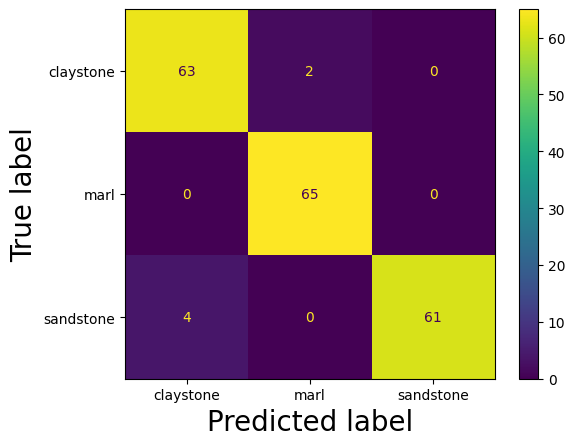

In [22]:
# ConfusionMatrixDisplay(pipe, X_test, y_test) # .5g to suppress scientific notation
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()
plt.show()

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   claystone       0.94      0.97      0.95        65
        marl       0.97      1.00      0.98        65
   sandstone       1.00      0.94      0.97        65

    accuracy                           0.97       195
   macro avg       0.97      0.97      0.97       195
weighted avg       0.97      0.97      0.97       195



## Modelling with more reduced feature

But after we make a Feature Importance plot of all features used in AdaBoost prediction.:
> Only 3 features, ECDBIT, TOTGAS, and ROP_AVG stand out with nearly equal importance of 30 to 35%.
>
>This means that the 3 features contribute the most to the ability to predict lithologies.

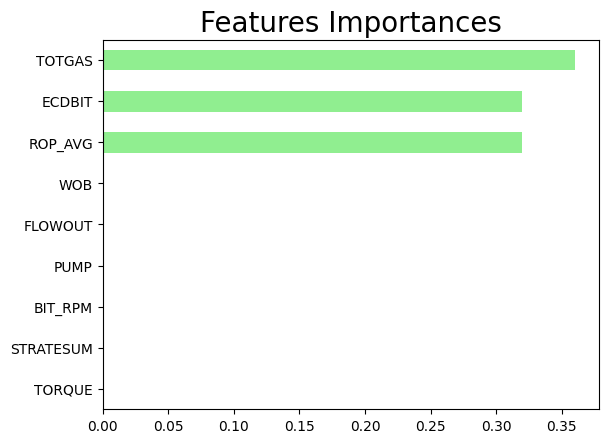

In [24]:
feature_importance = pipe.steps[2][1].feature_importances_

# Create a pd.Series of features importances
importances = pd.Series(data=feature_importance,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances', size=20)
plt.show()

Thus for new modelling we only using TOTGAS, ECDBIT and ROP_AVG

In [29]:
# Remove correlated features
exclude_feature = ['TORQUE', 'STRATESUM', 'BIT_RPM', 'PUMP', 'FLOWOUT','WOB']
df = df.drop(exclude_feature, axis=1)

df.head()

,Depth,ROP_AVG,TOTGAS,ECDBIT,LITH
0,3305.0,0.004088,0.000183,1360.8740,marl
1,3310.0,0.005159,0.000176,1382.0713,marl
2,3315.0,0.005971,0.000188,1381.7741,claystone
3,3320.0,0.005419,0.000276,1381.5933,claystone
4,3325.0,0.005435,0.000253,1381.1635,marl


In [30]:
# Drop depth column

# Separate feature and target
X, y = df.iloc[:,1:-1], df['LITH']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.30)
# Define oversampling
over = SMOTE(k_neighbors=4)

# Define model
model = AdaBoostClassifier()

# Define normalization
norm = StandardScaler()

# Put into pipeline
steps = [('norm', norm), ('o', over), ('model', model)]
pipe = Pipeline(steps=steps)

scoring = ['accuracy', 'precision_macro', 'recall_macro']
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores_pipe = cross_validate(pipe, X_train, y_train,
                            scoring=scoring, cv=cv, n_jobs=-1)

# Oversampling test data
over = SMOTE(k_neighbors=4)
X_test, y_test = over.fit_resample(X_test, y_test)

In [32]:
# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores_pipe['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores_pipe['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores_pipe['test_recall_macro']))

Mean Accuracy: 0.9782
Mean Precision: 0.9347
Mean Recall: 0.9456


In [33]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

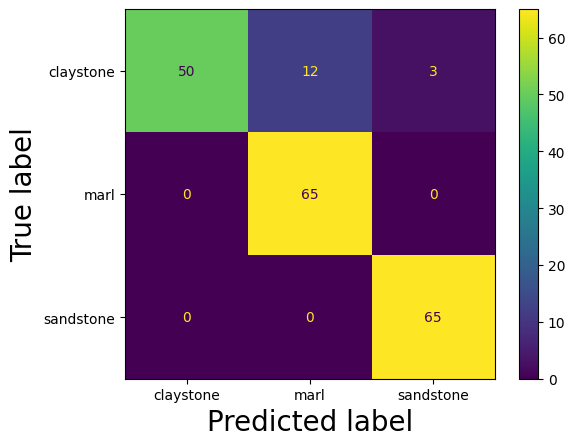

In [34]:
# ConfusionMatrixDisplay(pipe, X_test, y_test) # .5g to suppress scientific notation
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()
plt.show()

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   claystone       1.00      0.77      0.87        65
        marl       0.84      1.00      0.92        65
   sandstone       0.96      1.00      0.98        65

    accuracy                           0.92       195
   macro avg       0.93      0.92      0.92       195
weighted avg       0.93      0.92      0.92       195



In [36]:
# Generate class membership probabilities
y_pred_probs = pipe.predict_proba(X_test)

# Example prediction for observation no. 10
no_obs = 9
classes = ['claystone', 'marl', 'sandstone']
for i in range(len(classes)):
  print(f'{classes[i]}: {y_pred_probs[no_obs-1][i]:.3f}')

claystone: 0.411
marl: 0.000
sandstone: 0.589


Still show compartive performance after only using 3 features.

In [37]:
roc_auc_score(y_test, y_pred_probs, average="weighted", multi_class="ovr")

0.9455621301775148

## Download pipeline to deploy using pickle

In [40]:
from sklearn import datasets
from google.colab import drive
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/cerdas2'

Mounted at /content/drive/
/content/drive/My Drive/cerdas2


In [41]:
import pickle
with open('trained_pipeline-0.1.0.pkl','wb') as f:
    pickle.dump(pipe, f)